## Take care: 
Batch first (shape), 

Learning rate,

Optimizer,

Padding,

Architecture,

Transforms,

Preprocessing


In [1]:
import librosa
import pandas as pd
import torchaudio
import torch.optim as optim
import numpy as np
import csv
from difflib import SequenceMatcher
import os
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.functional import F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import librosa
from librosa.core import stft, magphase
from glob import glob
from torch import autograd
import csv
from data_load import CodeSwitchDataset
import zipfile

/home/dexter/Desktop/Projects/CodeSwitching/hparam.py:11: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  for doc in docs:


In [2]:
from data_load import TextTransform

In [3]:
def pad(wav, trans, lang):
    if lang == "Gujarati":
        max_len = 0
    elif lang == "Telugu":
        max_len = 529862
    elif lang == 'Tamil':
        max_len = 0
    else:
        raise Exception("Check Language")

    while len(wav) < max_len:
        diff = max_len - len(wav)
        ext = wav[:diff]
        wav = np.append(wav, wav[:diff])
        ratio = int(len(trans)*diff/len(wav))
        trans +=trans[:ratio]
    return wav, trans

def preprocess(data):
    #print(data)
    inputs = []
    labels = []
    input_lengths = []
    label_lengths = []
    
    for (wav, sr, trans, lang) in data:
        #wav, trans  = pad(wav, trans, lang)
        out = stft(wav, win_length=int(sr*0.02), hop_length=int(sr*0.01))
        out = np.transpose(out, axes=(1, 0))

        text_transform = TextTransform()
        trans = torch.Tensor(text_transform.text_to_int(trans.lower()))

        out = magphase(out)[0]
        out = torch.from_numpy(np.array([np.log(1 + x) for x in out]))
        inputs.append(out)
        labels.append(trans)
        input_lengths.append(out.shape[0])
        label_lengths.append(len(trans))
    inputs = nn.utils.rnn.pad_sequence(inputs, batch_first=True)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)
    #spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    return inputs, labels, input_lengths, label_lengths

def preprocess_crnn(data, mode = 'train'):
    #print(data)
    inputs = []
    labels = []
    if mode=='train':
        transform = nn.Sequential(
            torchaudio.transforms.MelSpectrogram(n_mels=128, sample_rate = 22050, n_fft = 500, win_length=int(22050*0.02), hop_length=int(22050*0.01)),
            torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
            torchaudio.transforms.TimeMasking(time_mask_param=35)
        )
    else:
        torchaudio.transforms.MelSpectrogram(n_mels=128, sample_rate = 22050, n_fft = 500, win_length=int(22050*0.02), hop_length=int(22050*0.01)),
    input_lengths = []
    label_lengths = []
    
    for (wav, sr, trans, lang) in data:
        #wav, trans  = pad(wav, trans, lang)
        out = transform(torch.Tensor(wav)).squeeze(0).transpose(0, 1)
        text_transform = TextTransform()
        trans = torch.Tensor(text_transform.text_to_int(trans.lower()))

        inputs.append(out)
        labels.append(trans)
        input_lengths.append(out.shape[0])
        label_lengths.append(len(trans))
    #inputs = nn.utils.rnn.pad_sequence(inputs, batch_first=True)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)
    inputs =  nn.utils.rnn.pad_sequence(inputs, batch_first=True).unsqueeze(1).transpose(2, 3)
    return inputs, labels, input_lengths, label_lengths

In [4]:
def GreedyDecoder(output, labels, label_lengths, blank_label=0, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    text_transform = TextTransform()
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

In [5]:
train_dataset = CodeSwitchDataset(lang = 'Telugu', mode = "train")
validation_split = 0.2
shuffle_dataset = True
random_seed= 42
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [6]:
train_loader = DataLoader(train_dataset,
                          batch_size=4,
                          drop_last=True,
                          num_workers = 6,
                          sampler = train_sampler,
                         collate_fn = lambda x: preprocess_crnn(x, 'train'))
test_loader = DataLoader(train_dataset,
                          batch_size=4,
                          drop_last=True,
                          num_workers = 6,
                          sampler = valid_sampler,
                         collate_fn = lambda x: preprocess_crnn(x, 'test'))

In [7]:
device = torch.device('cuda')

In [8]:
torch.cuda.empty_cache()

In [9]:
import torch.nn as nn
import torch

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=4, num_layers=4):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, bidirectional=True)
        # self.drop = nn.Dropout(0.25)
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        # print(type(self.lstm))
        # print(x.shape)
        lstm_out, hidden = self.lstm(x)
        # lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.linear(lstm_out)
        return out, hidden


class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_out_classes = 3
        self.conv = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        #self.conv4 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.hidden = nn.Linear(512, 128)
        self.drop = nn.Dropout(0.5)
        self.out1 = nn.Linear(8192, 512)
        self.out2 = nn.Linear(256, self.n_out_classes)
        self.act = nn.ReLU()
        self.avg_pool = nn.AdaptiveAvgPool2d((None, 512))
        self.num_layers = 2
        self.batch_size = 4
        self.hidden_size = 256
        self.bgru1 = nn.GRU(input_size=512,
                            hidden_size=256,
                            num_layers=2,
                           batch_first=True)

    def forward(self, x, x_lengths):
        #print("batch_size, seq_len, _ = ", x.size())
        seq_len = x.size()[-1]
        h0 = torch.rand(self.num_layers, self.batch_size, self.hidden_size).to(device)
        #print("Initial: ", x.shape)
        # [batch_size, channels, height, width]
        x = self.act(self.conv(x))  # [batch_size, 4, feats, seq_len]
        x = self.act(self.conv1(x))  # [batch_size, 8, 28, 28]
        x = self.act(self.conv2(x))  # [batch_size, 16, 26, 26]
        x = self.act(self.conv3(x))  # [batch_size, 32, 24, 24]
        #x = self.avg_pool(x)  # [batch_size, 32, 12, 12]
        #print("avg_pool: ", x.shape)
        #x = self.drop(x)
        x = x.permute(0,3,1,2)
        # [batch_size, width, channels, height]
        T = x.size(1)
        x = x.view(self.batch_size, T, -1)
        # [batch_size, width (time steps or length), channels * height]
        #x = self.hidden(x)  # [batch_size, 128]
        
        x = self.out1(x)
        # x = self.out1(x) # [batch_size, 64]
        x = nn.utils.rnn.pack_padded_sequence(x,
                                              x_lengths,
                                              enforce_sorted=False,
                                              batch_first=True)
        x, h0 = self.bgru1(x, h0)
        
        x, _ = nn.utils.rnn.pad_packed_sequence(x,
                                                batch_first=True)
        x = x.contiguous() 
        x = x.view(-1, x.shape[2])
        
        x = self.out2(x)  # [batch_size, 2]
        x = F.log_softmax(x, dim=1)
        x = x.view(self.batch_size, seq_len, self.n_out_classes)
        #x = self.bgru2(x)
        #print(x.shape)
        #x = self.out2(x)  # [batch_size, 2]
        return x

In [10]:
def train(model, device, train_loader, criterion, optimizer, epoch, iter_meter, writer):
    model.train()
    data_len = len(train_loader.dataset)
    total_loss=0
    LR = 0
    train_loss = 0
    avg_acc = 0
    acc = []
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (_data) in pbar:
        #bi, wav, label = batch_idx, wav, label
        for g in optimizer.param_groups:
            LR=g['lr']
        wav, labels, input_lengths, label_lengths = _data
        wav = wav.to(device)
        wav = wav.float()
        labels = labels.to(device)
        optimizer.zero_grad()
        #print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))
        output = model(wav, input_lengths)   #(batch, time, n_class) [4, 911, 3]
        output = output.transpose(0,1)
        #print(output.shape, labels.shape, len(input_lengths), len(label_lengths))
        loss = criterion(output, labels, input_lengths, label_lengths)
        #print(loss)
        total_loss+=loss
        loss.backward()
        
        optimizer.step()
        iter_meter.step()
        decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
        decoded_preds, decoded_targets = list(map(str.strip, decoded_preds)), list(map(str.strip, decoded_targets))
        for j in range(len(decoded_preds)):
            s = SequenceMatcher(None, decoded_targets[j], decoded_preds[j])
            acc.append(s.ratio())

        avg_acc = sum(acc)/len(acc)
        writer.add_scalar("train_accuracy", avg_acc, epoch)
        writer.add_scalar('train_loss', train_loss, epoch)
        writer.add_scalar('CTCLoss', loss, epoch*len(train_loader)+1)
        writer.add_scalar('TLoss', total_loss, epoch*len(train_loader)+1)
        writer.add_scalar("Learning Rate", LR, epoch)
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(wav), data_len,
                    100. * batch_idx / len(train_loader), loss.item()))
            print("Train Accuracy: {}, Train loss: {}".format(avg_acc, train_loss))
    for g in optimizer.param_groups:
        g['lr'] = g['lr']/LEARNING_ANNEAL
            
    print(decoded_preds[0])
    if (epoch+1)%2 == 0:
        model.eval().cpu()
        ckpt_model_filename = "ckpt_epoch_" + str(epoch+1) + "_batch_id_" + str(batch_idx+1) + ".pth"
        ckpt_model_path = os.path.join("checkpoints/", ckpt_model_filename)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, ckpt_model_path)
        model.to(device).train()

In [11]:
def test(model, device, test_loader, criterion, epoch, writer):
    model.eval()
    training_loss, train_acc = 0, 0
    eer, total_eer = 0, 0
    test_loss=0
    acc = []
    with torch.no_grad():
        for batch_idx, _data in enumerate(test_loader):
            inputs, labels, input_lengths, label_lengths = _data 
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs, input_lengths)  # (batch, time, n_class)
            output = output.transpose(0, 1) # (time, batch, n_class)
            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)
            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            decoded_preds, decoded_targets = list(map(str.strip, decoded_preds)), list(map(str.strip, decoded_targets))
            for j in range(len(decoded_preds)):
                s = SequenceMatcher(None, decoded_targets[j], decoded_preds[j])
                acc.append(s.ratio())

            avg_acc = sum(acc)/len(acc)
            writer.add_scalar("test_accuracy", avg_acc, epoch)
            writer.add_scalar('test_loss', test_loss, epoch)
            print("Test Accuracy: {}, Test loss: {}".format(avg_acc, test_loss))
        
    print(decoded_targets)
    print(decoded_preds)

In [12]:
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val

In [13]:
LEARNING_ANNEAL = 1.01

In [14]:
"""
model = Model(input_dim=1025,
              hidden_dim=1024,
              batch_size=4,
              output_dim=4,
              num_layers=4)
#model.half()
"""
model = Network()
model = model.to(device)
criterion = nn.CTCLoss(blank = 0).to(device)
epochs = 40
optimizer = optim.Adam(model.parameters(), 1e-3)

In [27]:
writer = SummaryWriter('train_logs/')
iter_meter = IterMeter()
#checkpoint = torch.load("checkpoints/ckpt_epoch_22_batch_id_822.pth")
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
model.to(device)
model.train()
for epoch in range(1, epochs+1):
    train(model, device, train_loader, criterion, optimizer, epoch, iter_meter, writer)
    test(model, device, test_loader, criterion, epoch, writer)
    
model.eval().cpu()
save_model_filename = "final_epoch_" + str(epoch + 1) + "_batch_id_" + str(batch_idx + 1) + ".model"
save_model_path = os.path.join("checkpoints", save_model_filename)
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, save_model_path)

print("\nDone, trained model saved at", save_model_path)

  0%|          | 1/1645 [00:03<1:47:16,  3.92s/it]

Train Epoch: 1 [0/8225 (0%)]	Loss: 15.337673
Train Accuracy: 0.1528608814607744, Train loss: 0


  6%|▌         | 101/1645 [00:31<06:57,  3.70it/s]

Train Epoch: 1 [400/8225 (6%)]	Loss: -0.562809
Train Accuracy: 0.001764406551347089, Train loss: 0


 12%|█▏        | 202/1645 [00:59<05:32,  4.35it/s]

Train Epoch: 1 [800/8225 (12%)]	Loss: -0.795801
Train Accuracy: 0.000886592346696796, Train loss: 0


 18%|█▊        | 301/1645 [01:26<06:23,  3.50it/s]

Train Epoch: 1 [1200/8225 (18%)]	Loss: -0.762752
Train Accuracy: 0.0005920433943058339, Train loss: 0


 24%|██▍       | 401/1645 [01:53<05:24,  3.83it/s]

Train Epoch: 1 [1600/8225 (24%)]	Loss: -0.752453
Train Accuracy: 0.0004444016500899152, Train loss: 0


 30%|███       | 501/1645 [02:21<04:26,  4.30it/s]

Train Epoch: 1 [2000/8225 (30%)]	Loss: -1.129731
Train Accuracy: 0.0003556987259202714, Train loss: 0


 37%|███▋      | 601/1645 [02:50<05:30,  3.16it/s]

Train Epoch: 1 [2400/8225 (36%)]	Loss: -0.764276
Train Accuracy: 0.0002965142457338702, Train loss: 0


 43%|████▎     | 701/1645 [03:17<05:03,  3.11it/s]

Train Epoch: 1 [2800/8225 (43%)]	Loss: -0.621104
Train Accuracy: 0.000254215494559281, Train loss: 0


 49%|████▊     | 801/1645 [03:47<03:36,  3.91it/s]

Train Epoch: 1 [3200/8225 (49%)]	Loss: -0.630048
Train Accuracy: 0.00022247822932091883, Train loss: 0


 52%|█████▏    | 851/1645 [04:02<03:35,  3.68it/s]

KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load("checkpoints/ckpt_epoch_22_batch_id_822.pth"))

In [40]:
checkpoint.keys()

odict_keys(['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'lstm.weight_ih_l2', 'lstm.weight_hh_l2', 'lstm.bias_ih_l2', 'lstm.bias_hh_l2', 'lstm.weight_ih_l3', 'lstm.weight_hh_l3', 'lstm.bias_ih_l3', 'lstm.bias_hh_l3', 'linear.weight', 'linear.bias'])

In [31]:
data_len = len(train_loader.dataset)
pbar = tqdm(enumerate(train_loader), total=len(train_loader))
for batch_idx, (_data) in pbar:
    #bi, wav, label = batch_idx, wav, label
    wav, labels, input_lengths, label_lengths = _data
    print(wav.shape)





  0%|          | 0/1645 [00:00<?, ?it/s]



  0%|          | 1/1645 [00:00<25:24,  1.08it/s]



  0%|          | 5/1645 [00:01<18:08,  1.51it/s]

torch.Size([4, 1, 128, 841])
torch.Size([4, 1, 128, 684])
torch.Size([4, 1, 128, 1080])
torch.Size([4, 1, 128, 989])
torch.Size([4, 1, 128, 1324])
torch.Size([4, 1, 128, 1373])






  0%|          | 7/1645 [00:01<14:46,  1.85it/s]



  1%|          | 12/1645 [00:01<10:33,  2.58it/s]

torch.Size([4, 1, 128, 1444])
torch.Size([4, 1, 128, 711])
torch.Size([4, 1, 128, 1238])
torch.Size([4, 1, 128, 1146])
torch.Size([4, 1, 128, 895])
torch.Size([4, 1, 128, 1244])






  1%|          | 14/1645 [00:02<09:25,  2.88it/s]

torch.Size([4, 1, 128, 1576])
torch.Size([4, 1, 128, 1207])
torch.Size([4, 1, 128, 1046])
torch.Size([4, 1, 128, 939])
torch.Size([4, 1, 128, 901])
torch.Size([4, 1, 128, 777])


KeyboardInterrupt: 

In [32]:
input_lengths

[777, 768, 589, 525]

In [33]:
wav.shape

torch.Size([4, 1, 128, 777])

In [34]:
label_lengths

[39, 39, 30, 27]

In [35]:
labels

tensor([[0., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 0.],
        [0., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 2., 2., 2., 2.,
         2., 0., 0.],
        [0., 0., 0., 0., 2., 2., 2., 2., 2., 2., 1., 1., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 2., 2., 2., 2., 2., 2., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [36]:
input_lengths

[777, 768, 589, 525]

In [38]:
wav, labels, input_lengths, label_lengths = _data
wav, labels = wav.to(device), labels.to(device)

output, _ = model(wav, input_lengths)  # (batch, time, n_class)
output = F.log_softmax(output, dim=1)
output = output.transpose(0, 1) # (time, batch, n_class)
loss = criterion(output, labels, input_lengths, label_lengths)

decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)

batch_size, seq_len, _ =  torch.Size([4, 1, 128, 777])
Initial:  torch.Size([4, 1, 128, 777])
conv:  torch.Size([4, 32, 126, 775])
conv1:  torch.Size([4, 32, 124, 773])
conv2:  torch.Size([4, 64, 122, 771])
conv3:  torch.Size([4, 64, 120, 769])
After reshape:  torch.Size([4, 769, 7680])
out1:  torch.Size([4, 769, 512])
[777, 768, 589, 525]
After packing:  4


RuntimeError: shape '[9, 1, 256]' is invalid for input of size 256

In [ ]:
print()

In [32]:
labels

tensor([[0., 0., 0., 0., 2., 2., 2., 2., 2., 1., 1., 2., 2., 2., 2., 2., 0., 0.,
         0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 0., 2., 2., 2., 0., 0., 0., 2.,
         2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 2., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 2., 2., 2., 2., 0.,
         0., 2., 2., 2., 2., 2., 2., 1., 1., 2., 2., 2., 2., 2., 2., 2., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [33]:
label_lengths

[47, 30, 35, 29]

In [34]:
input_lengths

[939, 603, 701, 568]

In [28]:
decoded_preds[0], len(decoded_preds[0])

NameError: name 'decoded_preds' is not defined

In [23]:
decoded_targets[0], len(decoded_targets[0])

('sstttttttsssssssssttssssssssssttttttttsttttsttttttttttttssttttttss', 66)

In [24]:
labels[0]

tensor([0., 0., 2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2.,
        2., 2., 0., 2., 2., 2., 2., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 1., 1., 2., 2., 2., 2., 2., 2., 0., 0.], device='cuda:0')

In [25]:
output.shape

torch.Size([1321, 8, 4])

In [26]:
inputs.shape

torch.Size([8, 1321, 1025])

In [18]:
pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (_data) in pbar:
        
for batch, dat in enumerate(train_dataset):
    inputs, labels, input_lengths, label_lengths = dat
    print(labels)

22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050


KeyboardInterrupt: 

In [16]:
for batch_idx, (_data) in enumerate(train_loader):
        print(batch_idx, _data)

0 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.8358e-03, 1.3930e-03, 6.4188e-05,  ..., 5.6660e-03,
           4.9603e-03, 9.5196e-04],
          [7.1016e-03, 5.3885e-03, 2.4830e-04,  ..., 2.1918e-02,
           1.9188e-02, 3.6825e-03],
          ...,
          [4.6775e-06, 4.4517e-15, 2.5741e-15,  ..., 6.7413e-16,
           9.5914e-16, 1.6345e-06],
          [4.6545e-06, 3.1472e-15, 2.8469e-15,  ..., 9.7882e-16,
           7.8074e-16, 1.6373e-06],
          [4.6986e-06, 3.4153e-15, 2.6617e-15,  ..., 6.7893e-16,
           1.1317e-15, 1.6597e-06]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.4027e-03, 9.3185e-04, 1.1325e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.0899e-02, 3.6047e-03, 4.3809e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.1662e-07, 8.6952e-16, 2.8349e-16,  ..., 0

6 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.5585e-04, 5.0613e-05, 1.4304e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.0286e-04, 1.9579e-04, 5.5332e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [7.1888e-11, 3.4893e-17, 6.7856e-17,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.2480e-11, 3.3068e-17, 7.0273e-17,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.3546e-11, 2.4101e-17, 3.9913e-17,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0

12 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.9450e-04, 9.3647e-04, 4.6382e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.9129e-03, 3.6225e-03, 1.7942e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.6276e-08, 1.6339e-14, 4.4029e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.8390e-08, 8.3367e-15, 3.3548e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.0296e-08, 8.5034e-15, 1.6115e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.5136e-05, 1.8985e-06, 3.3782e-07,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.8549e-05, 7.3440e-06, 1.3068e-06,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.4576e-09, 2.2967e-17, 6.9039e-17,  ..., 

18 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.9871e-07, 1.9157e-06, 2.4942e-06,  ..., 6.0156e-06,
           9.2923e-07, 2.8781e-06],
          [2.3160e-06, 7.4105e-06, 9.6482e-06,  ..., 2.3270e-05,
           3.5945e-06, 1.1133e-05],
          ...,
          [9.6058e-08, 1.0717e-16, 1.0629e-16,  ..., 1.0827e-16,
           2.1830e-17, 4.1773e-08],
          [9.5702e-08, 8.2360e-17, 8.6814e-17,  ..., 5.5941e-17,
           1.9883e-17, 4.1704e-08],
          [9.6682e-08, 5.5593e-17, 7.5803e-17,  ..., 3.7985e-17,
           1.0443e-17, 4.2183e-08]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.9523e-01, 3.9866e-03, 1.3671e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.5521e-01, 1.5421e-02, 5.2882e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.6813e-05, 3.2829e-14, 2.7740e-14,  ..., 

24 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.2933e-04, 4.7345e-04, 5.9726e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.0476e-03, 1.8314e-03, 2.3104e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.9456e-06, 1.5198e-14, 6.4220e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.9218e-06, 1.6745e-14, 7.4939e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.9813e-06, 1.6296e-14, 2.4304e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.8149e-04, 6.2461e-04, 1.8369e-03,  ..., 2.0727e-03,
           7.5173e-05, 2.9471e-04],
          [7.0206e-04, 2.4162e-03, 7.1057e-03,  ..., 8.0177e-03,
           2.9079e-04, 1.1400e-03],
          ...,
          [6.3429e-08, 3.0635e-17, 4.5604e-17,  ..., 

30 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.6822e-02, 1.4375e-02, 7.7383e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.9717e-01, 5.5606e-02, 2.9934e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.1252e-07, 4.3724e-14, 8.7607e-13,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7872e-07, 4.1732e-14, 9.2451e-13,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.6319e-07, 4.7003e-14, 7.2663e-13,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0680e-03, 2.8603e-03, 2.8044e-03,  ..., 2.0859e-04,
           4.3309e-04, 6.4079e-04],
          [4.1315e-03, 1.1065e-02, 1.0848e-02,  ..., 8.0687e-04,
           1.6753e-03, 2.4788e-03],
          ...,
          [1.6705e-06, 2.4143e-15, 8.8038e-16,  ..., 

36 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0668e-03, 4.0063e-04, 6.0527e-03,  ..., 7.6671e-03,
           3.3739e-04, 1.4587e-03],
          [1.5731e-02, 1.5497e-03, 2.3414e-02,  ..., 2.9658e-02,
           1.3051e-03, 5.6427e-03],
          ...,
          [2.3127e-07, 9.6677e-15, 1.9434e-15,  ..., 2.6585e-15,
           4.5633e-15, 1.3238e-04],
          [2.3431e-07, 9.2506e-15, 1.0943e-15,  ..., 2.2917e-15,
           5.8362e-15, 1.3258e-04],
          [2.3911e-07, 7.5582e-15, 5.0873e-15,  ..., 3.6436e-15,
           6.0600e-15, 1.3437e-04]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.1245e-05, 5.2784e-06, 3.2121e-06,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.3497e-05, 2.0418e-05, 1.2426e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.5029e-08, 5.1672e-17, 2.2487e-16,  ..., 

42 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4233e-05, 2.5038e-06, 2.2584e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.5059e-05, 9.6855e-06, 8.7362e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.3376e-10, 2.7007e-16, 2.3140e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.5121e-10, 2.1826e-16, 1.5474e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.6873e-10, 1.3981e-16, 1.5902e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.5009e-04, 1.3000e-03, 1.5343e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.3542e-03, 5.0287e-03, 5.9352e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [7.9772e-08, 6.1163e-16, 1.0014e-15,  ..., 

48 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.9976e-05, 1.4294e-04, 1.5686e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.3200e-04, 5.5295e-04, 6.0679e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [7.0875e-07, 5.3469e-15, 3.5528e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.1242e-07, 3.4908e-15, 1.9016e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.2351e-07, 3.0128e-15, 2.2095e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.2011e-02, 5.7383e-03, 2.5906e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.6463e-02, 2.2197e-02, 1.0021e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [8.9057e-07, 2.0333e-15, 2.0619e-15,  ..., 

54 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7450e-04, 3.4700e-03, 2.5296e-03,  ..., 3.6177e-03,
           4.2992e-04, 1.4469e-04],
          [1.0618e-03, 1.3423e-02, 9.7854e-03,  ..., 1.3994e-02,
           1.6631e-03, 5.5969e-04],
          ...,
          [8.1619e-08, 6.2595e-16, 3.9583e-16,  ..., 1.1174e-16,
           1.3294e-16, 2.4544e-07],
          [8.2387e-08, 5.4116e-16, 2.4997e-16,  ..., 1.4403e-16,
           1.0042e-16, 2.4272e-07],
          [8.3881e-08, 5.3505e-16, 2.7111e-16,  ..., 1.4085e-16,
           5.4669e-17, 2.4417e-07]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.3155e-04, 4.9240e-04, 6.0189e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.6035e-03, 1.9047e-03, 2.3283e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.1645e-06, 8.5417e-15, 1.4144e-14,  ..., 

60 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.0975e-04, 1.9191e-03, 4.5058e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.1982e-03, 7.4237e-03, 1.7430e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.5551e-07, 2.7474e-15, 2.7838e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.5102e-07, 2.1507e-15, 2.7055e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.5144e-07, 1.3891e-15, 2.0854e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.8376e-03, 9.3668e-02, 5.5244e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.4186e-02, 3.6233e-01, 2.1370e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.0295e-07, 1.6785e-15, 1.5782e-15,  ..., 

66 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.8762e-05, 2.7518e-04, 3.6869e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.6599e-04, 1.0645e-03, 1.4262e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.4299e-06, 4.0023e-15, 1.8092e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4129e-06, 2.7240e-15, 1.4757e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4327e-06, 2.0647e-15, 1.5252e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.9744e-01, 1.4039e-02, 3.9319e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.6375e-01, 5.4307e-02, 1.5210e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [8.4130e-05, 1.5358e-13, 5.2902e-14,  ..., 

72 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.6051e-03, 5.6737e-03, 4.4526e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.3287e-02, 2.1948e-02, 1.7224e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.3726e-08, 6.3217e-16, 7.0701e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.3235e-08, 4.3149e-16, 4.0798e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.3599e-08, 2.8889e-16, 4.4378e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.5202e-02, 3.0575e-03, 6.1352e-03,  ..., 1.2006e-03,
           8.8764e-04, 1.2400e-03],
          [5.8804e-02, 1.1827e-02, 2.3733e-02,  ..., 4.6444e-03,
           3.4336e-03, 4.7966e-03],
          ...,
          [3.6853e-07, 1.7959e-15, 4.7772e-16,  ..., 

75 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.0694e-04, 1.1011e-02, 5.4844e-03,  ..., 5.9459e-04,
           1.2415e-03, 1.5005e-04],
          [1.1873e-03, 4.2595e-02, 2.1215e-02,  ..., 2.3000e-03,
           4.8025e-03, 5.8043e-04],
          ...,
          [1.2431e-07, 1.4815e-15, 7.7052e-16,  ..., 1.6701e-16,
           8.5571e-17, 1.3690e-07],
          [1.2385e-07, 1.9239e-15, 4.8897e-16,  ..., 1.2356e-16,
           5.3735e-17, 1.3552e-07],
          [1.2511e-07, 2.0826e-15, 1.9775e-16,  ..., 1.0467e-16,
           7.3314e-17, 1.3639e-07]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.2902e-03, 9.1132e-04, 1.0811e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.9909e-03, 3.5253e-03, 4.1818e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.3653e-06, 1.9576e-15, 2.3775e-15,  ..., 

78 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.0851e-03, 3.4405e-03, 5.9111e-06,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.0658e-03, 1.3309e-02, 2.2866e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.7824e-05, 8.0783e-14, 1.6770e-13,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.7800e-05, 8.3123e-14, 1.1460e-13,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.8006e-05, 6.9165e-14, 1.0433e-13,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.8965e-06, 9.9088e-06, 9.7175e-06,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.1205e-05, 3.8330e-05, 3.7590e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.1241e-09, 1.4749e-16, 7.7572e-18,  ..., 

84 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.6744e-06, 2.4048e-05, 8.6125e-07,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.4772e-06, 9.3024e-05, 3.3316e-06,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.7334e-08, 5.9879e-16, 8.1155e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.6551e-08, 4.7163e-16, 6.3886e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.6787e-08, 4.4728e-16, 4.1219e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0256e-05, 9.0615e-06, 1.2201e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.9673e-05, 3.5053e-05, 4.7196e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.4180e-07, 7.2777e-16, 4.3495e-15,  ..., 

90 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.4787e-05, 8.7377e-05, 5.0104e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.3457e-04, 3.3800e-04, 1.9382e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.5111e-08, 3.6081e-16, 5.9571e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4663e-08, 2.0914e-16, 7.3301e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4578e-08, 1.9400e-16, 7.1166e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.0214e-03, 5.0434e-04, 3.4652e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.1688e-02, 1.9509e-03, 1.3405e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.7892e-06, 5.4733e-15, 1.0454e-15,  ..., 

96 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.5891e-04, 4.2395e-03, 2.6239e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0016e-03, 1.6400e-02, 1.0150e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.3182e-06, 8.6545e-15, 4.0299e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.3146e-06, 5.4667e-15, 3.5380e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.3414e-06, 4.0156e-15, 4.2076e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.3440e-02, 4.6321e-02, 2.3996e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.2277e-01, 1.7918e-01, 9.2825e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.7393e-05, 7.8657e-13, 2.1655e-14,  ..., 

102 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.9708e-04, 3.0266e-04, 1.8410e-04,  ..., 5.3519e-04,
           7.3624e-05, 4.1557e-04],
          [7.6235e-04, 1.1708e-03, 7.1216e-04,  ..., 2.0703e-03,
           2.8480e-04, 1.6076e-03],
          ...,
          [2.0423e-07, 9.6568e-16, 4.4893e-16,  ..., 6.3533e-16,
           8.6381e-16, 7.8756e-09],
          [2.0150e-07, 5.5222e-16, 4.3730e-16,  ..., 5.6367e-16,
           5.6978e-16, 7.9455e-09],
          [2.0237e-07, 4.4846e-16, 3.9147e-16,  ..., 4.8439e-16,
           2.2220e-16, 8.0872e-09]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.9267e-06, 3.2239e-07, 3.3028e-06,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.4531e-05, 1.2471e-06, 1.2776e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.1328e-07, 6.0374e-17, 1.9854e-16,  ...,

110 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2538e-06, 1.2523e-05, 4.4146e-06,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.7183e-06, 4.8444e-05, 1.7077e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.1695e-10, 5.2682e-17, 7.3717e-17,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0012e-10, 5.5989e-17, 4.6753e-17,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.1898e-11, 4.9280e-17, 2.5423e-17,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.5757e-04, 1.0330e-04, 1.5876e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.0955e-04, 3.9960e-04, 6.1413e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.1534e-07, 3.7878e-16, 7.0032e-17,  ...,

116 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.5406e-03, 2.9071e-04, 4.3570e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.5301e-02, 1.1246e-03, 1.6854e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.1034e-07, 2.3644e-16, 6.1613e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.0653e-07, 1.5823e-16, 4.7108e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.1058e-07, 1.8814e-16, 3.9392e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.7657e-03, 3.3371e-03, 1.1875e-03,  ..., 4.4425e-03,
           6.4297e-03, 4.6583e-02],
          [6.8304e-03, 1.2909e-02, 4.5936e-03,  ..., 1.7185e-02,
           2.4872e-02, 1.8020e-01],
          ...,
          [7.9922e-06, 5.4538e-15, 1.7198e-15,  ...,

122 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4062e-07, 2.9587e-07, 1.2907e-06,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.3079e-07, 1.1445e-06, 4.9926e-06,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.1596e-07, 9.1995e-16, 1.3578e-17,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.1407e-07, 7.6731e-16, 5.9100e-18,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.1557e-07, 6.7665e-16, 5.1293e-18,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.6965e-04, 3.9276e-04, 4.0912e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4299e-03, 1.5193e-03, 1.5826e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.0022e-07, 1.4864e-14, 8.1034e-15,  ...,

128 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.7297e-03, 2.5082e-05, 5.1913e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.8296e-02, 9.7024e-05, 2.0081e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.6807e-08, 2.4319e-13, 3.8673e-13,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.5511e-08, 1.9448e-13, 2.9472e-13,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.1706e-08, 2.1305e-13, 2.6653e-13,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.4451e-04, 2.0171e-04, 6.4628e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.1063e-03, 7.8025e-04, 2.5000e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.5321e-08, 3.5505e-16, 2.6447e-16,  ...,

133 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4054e-04, 4.7257e-05, 3.3492e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.3046e-04, 1.8280e-04, 1.2956e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.2154e-07, 1.6232e-16, 3.7850e-17,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.2070e-07, 1.4951e-16, 2.2298e-17,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.2171e-07, 1.3132e-16, 1.2866e-17,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.3464e-05, 5.5413e-07, 4.6071e-06,  ..., 2.0425e-06,
           5.2269e-06, 3.1933e-06],
          [9.0767e-05, 2.1435e-06, 1.7822e-05,  ..., 7.9010e-06,
           2.0219e-05, 1.2353e-05],
          ...,
          [1.5871e-07, 4.1868e-16, 8.4789e-16,  ...,

140 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2481e-03, 9.0335e-04, 1.0726e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.6963e-03, 3.4944e-03, 4.1491e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.5284e-06, 2.2654e-13, 3.2547e-13,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4641e-06, 2.1731e-13, 2.4531e-13,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4566e-06, 1.7711e-13, 1.8526e-13,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.4486e-07, 3.2042e-06, 2.4006e-06,  ..., 8.8639e-06,
           2.0826e-07, 2.6168e-05],
          [3.6550e-06, 1.2395e-05, 9.2863e-06,  ..., 3.4288e-05,
           8.0560e-07, 1.0123e-04],
          ...,
          [3.8104e-08, 7.5557e-17, 1.0902e-17,  ...,

144 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.7915e-03, 2.4089e-02, 1.4209e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4667e-02, 9.3182e-02, 5.4964e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [7.5354e-09, 1.5165e-15, 1.7108e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.4895e-09, 9.6125e-16, 7.5284e-17,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.5540e-09, 1.1810e-15, 4.6455e-17,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.6763e-03, 3.3834e-03, 1.1928e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0353e-02, 1.3088e-02, 4.6142e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [7.0183e-08, 8.8839e-16, 4.4233e-17,  ...,

150 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.8744e-04, 6.3027e-04, 3.6061e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.8197e-03, 2.4381e-03, 1.3949e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.2301e-04, 1.5676e-13, 1.3519e-14,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.2291e-04, 1.3241e-13, 7.4569e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.2439e-04, 1.2944e-13, 7.4205e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.9772e-03, 3.8234e-04, 3.9641e-03,  ..., 3.7786e-03,
           6.4191e-04, 6.9037e-04],
          [3.0858e-02, 1.4790e-03, 1.5334e-02,  ..., 1.4617e-02,
           2.4831e-03, 2.6706e-03],
          ...,
          [1.0220e-06, 3.9801e-15, 1.3312e-15,  ...,

153 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.3903e-03, 4.9198e-04, 9.6071e-04,  ..., 8.4766e-05,
           6.1513e-04, 7.8495e-04],
          [5.3781e-03, 1.9031e-03, 3.7163e-03,  ..., 3.2790e-04,
           2.3795e-03, 3.0364e-03],
          ...,
          [1.9663e-07, 1.0961e-16, 5.4763e-16,  ..., 2.3208e-16,
           1.6304e-15, 5.3397e-09],
          [1.9489e-07, 5.6944e-17, 5.3707e-16,  ..., 1.1197e-16,
           1.0364e-15, 5.3335e-09],
          [1.9627e-07, 5.9377e-17, 4.6005e-16,  ..., 8.9636e-17,
           9.2043e-16, 5.3942e-09]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.7050e-04, 1.7658e-03, 5.2146e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.3674e-03, 6.8308e-03, 2.0172e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.9009e-07, 5.0944e-16, 3.9102e-16,  ...,

158 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4848e-05, 1.7418e-04, 2.5580e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.7436e-05, 6.7376e-04, 9.8951e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.6490e-10, 1.4230e-17, 1.2508e-17,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4300e-10, 7.0159e-18, 9.7671e-18,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.3330e-10, 9.7185e-18, 7.3007e-18,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.1075e-06, 5.1878e-07, 3.8394e-07,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.2840e-06, 2.0068e-06, 1.4852e-06,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.7600e-11, 1.6271e-16, 1.3674e-16,  ...,

162 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4976e-05, 2.0517e-06, 1.4541e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.7932e-05, 7.9367e-06, 5.6250e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.7196e-08, 9.1492e-16, 1.7883e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.6398e-08, 1.1101e-15, 1.2619e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.6747e-08, 1.0131e-15, 1.0722e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.2118e-04, 2.3399e-04, 1.1440e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4029e-03, 9.0516e-04, 4.4255e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.4116e-07, 2.9543e-16, 6.1068e-16,  ...,

165 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4314e-06, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.5371e-06, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.4797e-08, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4308e-08, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4195e-08, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.6036e-04, 4.3855e-04, 5.3296e-04,  ..., 3.8305e-05,
           3.1094e-03, 3.8690e-03],
          [3.3281e-03, 1.6964e-03, 2.0617e-03,  ..., 1.4817e-04,
           1.2028e-02, 1.4966e-02],
          ...,
          [7.7090e-09, 2.8411e-16, 4.2311e-16,  ...,

168 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.1040e-05, 5.6793e-06, 2.3152e-06,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.1389e-05, 2.1969e-05, 8.9558e-06,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.5421e-08, 1.3590e-16, 5.4818e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.4614e-08, 7.6826e-17, 4.3387e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.4567e-08, 3.5838e-17, 2.6353e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.0082e-06, 1.7907e-06, 1.2615e-05,  ..., 2.7765e-05,
           3.6165e-06, 1.2047e-05],
          [7.7683e-06, 6.9269e-06, 4.8798e-05,  ..., 1.0740e-04,
           1.3990e-05, 4.6602e-05],
          ...,
          [1.8983e-08, 8.6122e-17, 7.7606e-17,  ...,

174 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.3530e-01, 1.5733e-02, 9.4820e-03,  ..., 5.0018e-04,
           0.0000e+00, 0.0000e+00],
          [5.2339e-01, 6.0861e-02, 3.6679e-02,  ..., 1.9348e-03,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.3390e-05, 9.6385e-14, 3.0843e-15,  ..., 2.2155e-04,
           0.0000e+00, 0.0000e+00],
          [5.3230e-05, 8.3292e-14, 2.2162e-15,  ..., 2.2227e-04,
           0.0000e+00, 0.0000e+00],
          [5.3797e-05, 8.0463e-14, 2.8894e-15,  ..., 2.2552e-04,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.3205e-03, 3.5454e-04, 4.0304e-03,  ..., 6.7788e-04,
           3.0382e-04, 6.2868e-04],
          [5.1081e-03, 1.3715e-03, 1.5591e-02,  ..., 2.6222e-03,
           1.1753e-03, 2.4319e-03],
          ...,
          [2.6448e-07, 4.6511e-16, 5.9889e-17,  ...,

180 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.4321e-07, 9.6584e-06, 2.7331e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.4881e-06, 3.7362e-05, 1.0572e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.5224e-07, 9.2070e-15, 1.7158e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.5248e-07, 6.7341e-15, 2.2942e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.5578e-07, 5.2960e-15, 2.4681e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.6164e-02, 3.4717e-02, 9.9877e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.2526e-02, 1.3429e-01, 3.8635e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.1119e-06, 7.8123e-15, 1.0915e-15,  ...,

186 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.0599e-05, 1.1477e-06, 1.4764e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.1836e-04, 4.4397e-06, 5.7113e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.1039e-08, 2.3513e-16, 3.1078e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0549e-08, 1.1565e-16, 1.5065e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.0760e-08, 5.5035e-17, 1.2508e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.5063e-05, 9.2098e-05, 3.8435e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.7432e-04, 3.5626e-04, 1.4868e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.2708e-08, 9.7540e-15, 6.6801e-15,  ...,

192 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.2607e-08, 1.4024e-06, 7.4937e-07,  ..., 3.0407e-06,
           5.8964e-07, 1.5436e-06],
          [3.1955e-07, 5.4249e-06, 2.8988e-06,  ..., 1.1762e-05,
           2.2809e-06, 5.9710e-06],
          ...,
          [1.2957e-07, 1.4579e-16, 5.5354e-16,  ..., 4.6300e-17,
           1.9370e-17, 1.7235e-10],
          [1.2873e-07, 1.2256e-16, 3.7427e-16,  ..., 5.3128e-17,
           1.0558e-17, 1.8098e-10],
          [1.2983e-07, 9.8944e-17, 3.5274e-16,  ..., 4.5172e-17,
           8.8654e-18, 1.8854e-10]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2510e-04, 3.9818e-04, 9.2458e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.7075e-04, 1.5403e-03, 3.5766e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.0768e-07, 3.3495e-16, 3.5628e-16,  ...,

199 (tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.8968e-07, 1.3758e-03, 5.0629e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.5766e-10, 6.1783e-17, 2.6940e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.0543e-10, 6.4594e-17, 2.7872e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.4280e-10, 6.4648e-17, 2.4764e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7969e-03, 2.5277e-03, 8.4468e-04,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0819e-02, 9.7780e-03, 3.2675e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.8257e-06, 5.8664e-15, 1.1046e-15,  ...,

KeyboardInterrupt: 

In [17]:
_data

(tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [1.7827e-07, 1.0861e-04, 8.9548e-05,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [6.8962e-07, 4.2013e-04, 3.4640e-04,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [3.3173e-07, 8.8060e-16, 2.5907e-17,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [3.3264e-07, 5.7686e-16, 3.2819e-17,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [3.3735e-07, 5.4215e-16, 3.2594e-17,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00]]],
 
 
         [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [5.0101e-05, 1.4215e-03, 2.2667e-03,  ..., 8.6389e-04,
            8.3774e-04, 3.5011e-04],
           [1.9380e-04, 5.4988e-03, 8.7682e-03,  ..., 3.3418e-03,
            3.2406e-03, 1.3543e-03],
           ...,
           [7.3400e-08, 3.9713e-16,

In [29]:
len(_data), _data[0].shape, _data[1].shape, len(_data[2]), len(_data[3])

(4, torch.Size([4, 1, 128, 858]), torch.Size([4, 43]), 4, 4)

In [31]:
_data[2], _data[3]

([614, 858, 813, 760], [31, 43, 41, 38])

In [26]:
for batch, dat in enumerate(train_loader):
    inputs, labels, input_lengths, label_lengths = dat
    inputs = inputs.to(device)
    output, _ = model(inputs)  # (batch, time, n_class)
    output = F.log_softmax(output, dim=1)
    output = output.transpose(0, 1) # (time, batch, n_class)
    loss = criterion(output, labels, input_lengths, label_lengths)

    decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
    print(decoded_targets)
    print(decoded_preds)
    
    print(len(decoded_preds[0]))

torch.Size([4, 32, 126, 1184])
torch.Size([4, 32, 124, 1182])
torch.Size([4, 32, 122, 1180])
torch.Size([4, 32, 120, 1178])
torch.Size([4, 32, 60, 589])


RuntimeError: size mismatch, m1: [7680 x 589], m2: [256 x 128] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:290

In [34]:
inputs[0][0].shape

torch.Size([128, 1186])

In [35]:
for g in optimizer.param_groups:
    g['lr'] = 3e-4

In [30]:
(1e-3)/pow(1.01,12)

0.0008874492252651537

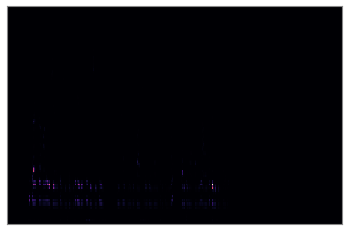

In [55]:
display.specshow(inputs[0][0].cpu().numpy())

In [21]:
tr = torchaudio.transforms.MelSpectrogram()

In [25]:
tr(torch.Tensor(inputs)).shape

torch.Size([128, 825])

In [23]:
inputs

array([ 5.2072178e-04,  4.2007118e-04, -4.8427330e-05, ...,
        9.5045177e-04,  8.1745436e-04,  2.9107300e-04], dtype=float32)

In [39]:
model.train()
data_len = len(train_loader.dataset)
total_loss=0
LR=0
train_loss=0
avg_acc=0
acc=[]
pbar = tqdm(enumerate(train_loader), total=len(train_loader))
for batch_idx, (_data) in pbar:
    #bi, wav, label = batch_idx, wav, label
    for g in optimizer.param_groups:
        LR=g['lr']
    wav, labels, input_lengths, label_lengths = _data
    wav = wav.to(device)
    wav = wav.float()
    labels = labels.to(device)
    optimizer.zero_grad()
    #print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))
    print(wav.shape, labels.shape, input_lengths.shape, label_lengths.shape)
    output, _ = model(wav)
    output = F.log_softmax(output, dim=1)
    output = output.transpose(0,1)
    #print(output.shape)
    print(output.shape, labels.shape, len(input_lengths), len(label_lengths))
    loss = criterion(output, labels, input_lengths, label_lengths)
    
    #print(loss)
    total_loss+=loss
    loss.backward()

    optimizer.step()
    iter_meter.step()
    decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
    decoded_preds, decoded_targets = list(map(str.strip, decoded_preds)), list(map(str.strip, decoded_targets))
    for j in range(len(decoded_preds)):
        s = SequenceMatcher(None, decoded_targets[j], decoded_preds[j])
        acc.append(s.ratio())

    avg_acc = sum(acc)/len(acc)
    writer.add_scalar("train_accuracy", avg_acc, epoch)
    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('CTCLoss', loss, epoch*len(train_loader)+1)
    writer.add_scalar('TLoss', total_loss, epoch*len(train_loader)+1)
    writer.add_scalar("Learning Rate", LR, epoch)
    if batch_idx % 100 == 0 or batch_idx == data_len:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(wav), data_len,
                100. * batch_idx / len(train_loader), loss.item()))
        print("Train Accuracy: {}, Train loss: {}".format(avg_acc, train_loss))
for g in optimizer.param_groups:
    g['lr'] = g['lr']/LEARNING_ANNEAL

print(decoded_preds[0])
if (epoch+1)%2 == 0:
    model.eval().cpu()
    ckpt_model_filename = "ckpt_epoch_" + str(epoch+1) + "_batch_id_" + str(batch_idx+1) + ".pth"
    ckpt_model_path = os.path.join("checkpoints/", ckpt_model_filename)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, ckpt_model_path)
    model.to(device).train()






  0%|          | 0/1645 [00:00<?, ?it/s]

AttributeError: 'int' object has no attribute 'shape'

In [25]:
wav.shape

torch.Size([4, 1, 128, 1239])

In [26]:
len(labels)

4

In [32]:
labels[0].shape

torch.Size([62])

In [28]:
input_lengths

[1239, 816, 430, 545]

In [29]:
label_lengths

[62, 41, 22, 43]

In [38]:
wav[3].shape

torch.Size([1, 128, 1239])

In [53]:
wav.shape, labels, input_lengths, label_lengths

(torch.Size([4, 1, 128, 786]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
          1., 1., 1., 0., 0., 2., 2., 2., 2., 2., 2., 0., 2., 2., 2., 2., 1., 1.,
          2., 2., 2., 0.],
         [0., 0., 0., 0., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
          2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
          2., 2., 2., 2., 2., 0., 2., 2., 2., 2., 2., 2., 0., 2., 2., 2., 2., 2.,
          2., 0., 0., 0.],
         [0., 0., 1., 1., 1., 1., 2., 2., 2., 2., 0., 2., 2., 2., 2., 2., 2., 2.,
          2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]]),
 [786, 421, 762, 418],
 [40, 21, 38, 21])

In [21]:
wav.shape, labels, input_lengths, label_lengths

(torch.Size([4, 1, 128, 939]),
 tensor([[0., 0., 0., 0., 2., 2., 2., 2., 2., 1., 1., 2., 2., 2., 2., 2., 0., 0.,
          0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 0., 2., 2., 2., 0., 0., 0., 2.,
          2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 2., 2., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
          2., 2., 2., 2., 2., 2., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 2., 2., 2., 2., 0.,
          0., 2., 2., 2., 2., 2., 2., 1., 1., 2., 2., 2., 2., 2., 2., 2., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 [939, 603, 701, 568],
 [47, 30, 35, 29])

In [22]:
input_lengths

[939, 603, 701, 568]

In [25]:
labels[0].shape

torch.Size([47])